## Credit Card Customer Segmentation

The problem described in this dataset requires us to extract segments of customers depending on their behaviour patterns provided in the dataset, to focus marketing strategy of the company on a particular segment.

Let's first load the dataset and take a quick look at it to decide our approach towards solving this problem.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [ ]:
df = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.isna().mean()*100

Looking at the reports we can see that most of the features have mean way greater than their median. This is a sign of some skewness in the dataset and we have to see if we can do something about it.

We also have some Nan values to impute there.

## Data Processing

Customer ID seems to be an unique id for each customer and hence won't play any role in determining the cluster.

In [ ]:
df.drop(['CUST_ID'], axis=1, inplace=True)

We have seen that credit limit feature has just 0.01% of records having Nan value i.e just 1 record here has missing value. So we don't have to take the trouble to impute it. We can simply drop it and never think about it again.

In [ ]:
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)

For imputing minimum payments feature, I don't see any column which has relation with this feature and help us estimate values for missing records. It seems that the values are missing at random and we can simply use median to replace the Nan values as the distribution for minimum payments is skewed and hence median gives a better estimation of the central tendency of this feature.

In [ ]:
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

Are we even data scientist if we don't visualize?

Let's visualize how skewed our dataset is.

In [ ]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

Woah!! There is a lot of skewness and they are varied. It is kind of expected from datasets like these as there will always be a few customers who do very high amount of transactions.

Now it depends on our application whether we want to handle the skewness in our dataset or not for a clustering problem. For instance if we want to do clustering for anamoly detection in that case we wouldn't want to handle the outliers as we would like our model to detect them and group them in a cluster. For our application I am looking for a good visualization so I would like to handle the skewness as much as possible as it will help the model to form better clusters.

Let's see if we can do something about this.

In [ ]:
cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [ ]:
for col in cols:
    df[col] = np.log(1 + df[col])

In [ ]:
plt.figure(figsize=(15,20))
for i, col in enumerate(cols):
    ax = plt.subplot(6, 2, i+1)
    sns.kdeplot(df[col], ax=ax)
plt.show()

I know it may not look like an ideal distribution but it is better than what we had and it is our job as data scientist to help our model as much as possible.

Looking for some correlation now.

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

We've got some correlated features there. There are many ways to handle this. We would go ahead with dimensionality reduction and we will bring our data down to lower dimension.

We will use PCA for our dimensionality reduction.

To explain briefly what PCA does under the hood is that it finds new dimension/axis for the dataset such that it explains maximum variance. That axis is then the first principal component. Then it chooses another component perpendicular to first principal component which explains maximum variance.

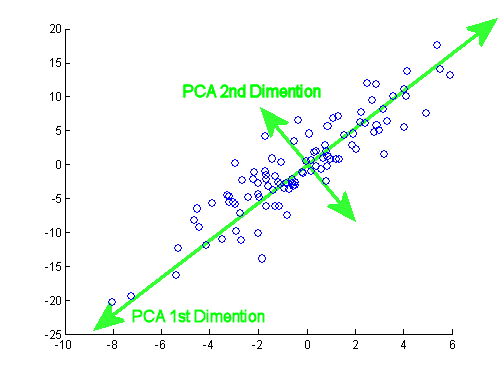

So for above image, If we project all points on PCA 1st dimension then the points are more spread out than if we do it on any other axis. This means that PCA 1st dimension explains maximum variance and hence it is our 1st principal component. Now we consider components which are perpendicular to this component and since this data is 2 dimensional we just have 1 component perpendicular to our 1st principal component and it becomes our 2nd principal component.

Note: If we had 3rd dimension coming out from the screen then we would have 2 components perpendicular to our 1st principal components and we would have to choose the one which explains maximum variance of the two.

Once we have these principal components, we can choose the number of components we wish to have and then express our data in terms of those principal components and thus reducing the dimensions.

So let's do the same in our case. We will select the number of components such that our data in the lower dimensions explains 95% of variance of our original data.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_red = pca.fit_transform(df)

With that we are ready to do what we have always wanted to do i.e Clustering. We will use Kmeans clustering algorithm to extraxts clusters of information from our dataset.

## Model Training

It is quite interesting and intuitive to know how KMeans clustering algorithm actually works.

KMeans clustering is an unsupervised clustering algorithm which groups together similar data in same cluster to form k clusters. As a result we get groups of similar records which can then be labelled and acted upon accordingly.

How does the algorithm find the clusters?

1. Given number of clusters k, it first selects k random point (may not be points in dataset) to be the k cluster centroids.

2. Then we assign each point to the closest centroid and form k clusters.

3. Once all points are assigned to a cluster, we then compute new centroids for each cluster.

4. Then we reassign points to the closest centroid.

5. If any reassignment takes place in step 4 we repeat steps 3 and 4. If no reassignment takes place then our model is ready and we have extracted k clusters from our dataset.

This process is explained in the diagram below.

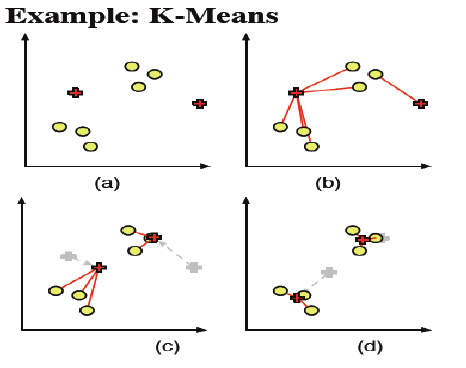

There is a catch though. As the algorithm itself starts with a random initialization of k points alot depends on that initialization. Since our real world data is not as well separated as in the above figure , it may so happen that the model intializes the k points such a way that we may end up with a suboptimal solution.

To avoid such a case, we can run the algorithm multiple times with random initial points for each iteration. Running the model multiple times ensures that atleast one of the time we avoid bad initalization and reach the optimal solution. Scikit learn actually trains a KMeans model 10 times and it can we controlled with the help if *n_init* hyperparameter.

To measure which model performs better out the n random initalization we can use model innertia or wcss (Within Cluster Summation of Squares). It measure sum of distance of each point from its centroid. So we want compact clusters with point as close as possible to its centroid.

Another approch to avoid bad initialization is using KMeans++ algorithm to initialize centroids. This algorithms initializes centroids in such a way that the cenrtoid chosen are as far as possible to each other thus ensures that we do not have suboptimal solution. This alogrithm along with the previous approach ensures that we obtain the best solution possible. Scikit learn uses KMeans++ algorithm to initalize centroids and is given by *init* hyperparameter.

This entire discussion until this point revolves around the assumption that we know number of clusters n. Thus n is the most important hyperparameter here and it is necessary to initalize n to its appropriate value.

To get the value of n we cannot use innertia as our metric as innertia keeps on increasing as we increase number of clusters. Think about it, if we initialize n to the number of points in dataset innertia will be minimum.

One way could be to plot the graph of n versus innertia and as we plot the graph we can spot an elbow after which the innertia decreases at a much lower rate. If we can use n corresponding to this elbow point as our number of clusters.

Another approach is to calculate silhouette score which is given as (b-a)/min(a,b) where b -> mean distance to the instances of nearest cluster, a -> mean distance to other instances of same cluster. So silhouette score penalizes the model is the mean distance to points of other cluster decreases and mean distance to the points of same cluster increases. While it rewards the model if mean distance to points of other cluster increases and mean distance to points of same cluster decreases. Thus we can select a model with highest silhouette score.

Phew! You still here? Well enough of theory. Let's see all of this in practice.

In [ ]:
from sklearn.cluster import KMeans

kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(X_red) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

You see the elbow there? It seems like the elbow is around 3 or 4 . We will use silhouette score to see which one performs better.

In [ ]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(X_red, model.labels_) for model in kmeans_models[1:4]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([2, 3, 4])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

Well, we were wrong n=2 seems to have higher silhouette than the other two. It is what it is, we will select 2 as our number of clusters.

## Model Evaluation and Inference.

In [ ]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=23)
kmeans.fit(X_red)

print('Silhoutte score of our model is ' + str(silhouette_score(X_red, kmeans.labels_)))

Assigning labels as cluster index to our dataset.

In [ ]:
df['cluster_id'] = kmeans.labels_

Inverse transforming the log transformation that we did earlier to visualize the results on original scale.

In [ ]:
for col in cols:
    df[col] = np.exp(df[col])

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on Credit limit and total purchases')
plt.show()

Looking at the above 2 plots it seems like our model has clustered customers with low usage of credit card in one cluster and model with higher usage of clusters in other. Great! we direct of resources accordingly.

### Extra:

3 seems to be an elbow so I wonder what would the model look like with 3 clusters lets see.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=23)
kmeans.fit(X_red)

In [ ]:
df['cluster_id'] = kmeans.labels_

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='ONEOFF_PURCHASES', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_id')
plt.title('Distribution of clusters based on Credit limit and total purchases')
plt.show()

Personally to me this seems like better clustering as it really segments out top half of customers having more than usual amount of usage of credit card and the customers which have very low usage. This seems to be more actionable result if we want to direct our marketing strategies according to usage of credit card.

Thanks for hanging around till the end. I would love to read your thoughts below.